In [1]:
import pandas as pd 
import math
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold

In [63]:
#Reading the data
#   data = pd.read_csv("mfccToy2.csv",header=None)
data_csv = pd.read_csv("data_emotify.csv")
data = pd.DataFrame(data_csv).to_numpy()
data.shape
data_csv

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,0,26,1,Russian
8403,400,pop,0,0,0,1,0,0,1,0,1,3,0,1,29,0,Russian
8404,400,pop,0,0,0,0,0,0,0,1,0,4,0,1,34,1,Polish
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,0,39,1,French


In [31]:
X_emotions = data[:,2:-6]
target = data[:,1]
print(X_emotions[0][1]+1)

2


### Statistics about emotions per genre
We wanted first to analyze the tendency of emotions for each genre

In [93]:
def extract_statistics(like = 2, gender = 2):
    '''This function summarizes the number of true values for each emotion in each genre
        Input:
       like : an int, is 0 if I only want to include information about songs people disliked, 1 about people who liked the songs, 2 about both (default)
       gender: an int, is 0 if I only want to include information of males, 1 females, 2 about both (default)
    '''
    summarize = np.zeros((4,10)) # The first nine columns are the sums of how many ones per emotion and the last one is the total of reviews per genre
    #compute total
    for song in range(X_emotions.shape[0]):
        if(target[song] == 'classical'):
            genre = 0
        if(target[song] == 'rock'):
            genre = 1
        if(target[song] == 'electronic'):
            genre = 2
        if(target[song] == 'pop'):
            genre = 3
    
        if(like == 2):
            if(gender == 2):
                summarize[genre][9] += 1
            else:
                if(data[song][-2] == gender):
                    summarize[genre][9] += 1
        else:
            if(gender == 2):
                if(data[song][-5] == like):
                    summarize[genre][9] += 1
                else:
                    if(data[song][-5] == like and data[song][-2] == gender):
                        summarize[genre][9] += 1


            
    for emotion in range(X_emotions.shape[1]):
        for song in range(X_emotions.shape[0]):
            if(target[song] == 'classical'):
                genre = 0
            if(target[song] == 'rock'):
                genre = 1
            if(target[song] == 'electronic'):
                genre = 2
            if(target[song] == 'pop'):
                genre = 3
            
            if(like == 2):
                if(gender == 2):
                    summarize[genre][emotion] += X_emotions[song][emotion]
                else:
                    if(data[song][-2] == gender):
                        summarize[genre][emotion] += X_emotions[song][emotion]
            else:
                if(gender == 2):
                    if(data[song][-5] == like):
                        summarize[genre][emotion] += X_emotions[song][emotion]
                    else:
                        if(data[song][-5] == like and data[song][-2] == gender):
                            summarize[genre][emotion] += X_emotions[song][emotion]
            
    
    return summarize

In [94]:
def plot_bar_emotions(genre,data_emotions):
    ''' This function receives an int that represents the genre
        0 for classical
        1 for rock
        2 for electronic
        3 for pop
        and the data
        and plots the bar diagram
        '''
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = ["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness"]
    fig.set_size_inches(10, 5, forward=True)
    students = data_emotions[genre,:-1]/data_emotions[genre,-1]
    gen = ['classical','rock','electronic','pop']
    plt.title('Emotions in '+gen[genre])
    plt.xlabel('Emotion')
    plt.ylabel('Percentage')
    barlist = ax.bar(langs,students)
    barlist[0].set_color('yellow')
    barlist[1].set_color('mediumpurple')
    barlist[2].set_color('lightpink')
    barlist[3].set_color('darkslateblue')
    barlist[4].set_color('PaleTurquoise')
    barlist[5].set_color('red')
    barlist[6].set_color('greenyellow')
    barlist[7].set_color('black')
    barlist[8].set_color('darkgrey')
    plt.show()

In [144]:
def plot_bar_emotions_compare(genre,data1,data2,tag1,tag2,title):
    ''' This function receives an int that represents the genre
        0 for classical
        1 for rock
        2 for electronic
        3 for pop
        and plots the bar diagram comparing information in data1 and data2
        tag1 and tag2 correspond to the names of the groups we are comparing
        title is the title of the plot
       '''
    n_groups = 9
    emotions_1 = data1[genre,:-1]/data1[genre,-1]
    emotions_2 = data2[genre,:-1]/data2[genre,-1]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5, forward=True)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, emotions_2, bar_width,
    alpha=opacity,
    color='b',
    label=tag1)

    rects2 = plt.bar(index + bar_width, emotions_1, bar_width,
    alpha=opacity,
    color='g',
    label=tag2)

    plt.xlabel('Emotion')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(index + bar_width, ["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness"])
    plt.legend()

    plt.tight_layout()
    plt.show()

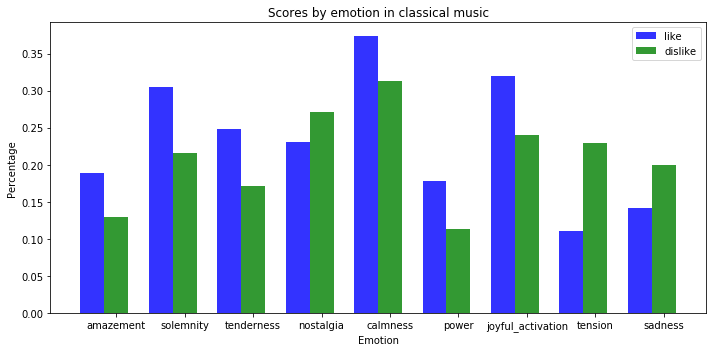

In [145]:
plot_bar_emotions_compare(0,summarize_emotions_dislike,summarize_emotions_like,"like","dislike","Scores by emotion in classical music")

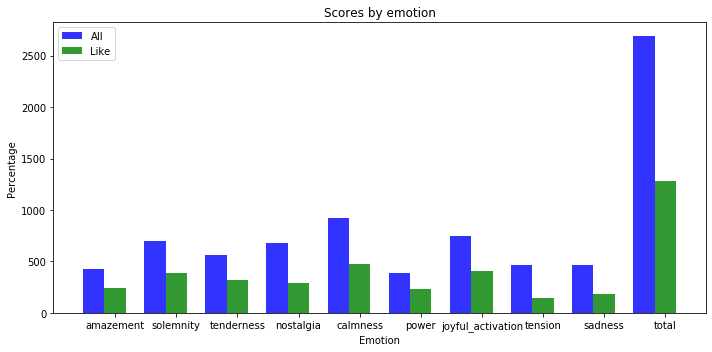

In [127]:
n_groups = 10
emotions_all = summarize_emotions[0]
emotions_like = summarize_emotions_like[0]
emotions_dislike = summarize_emotions_like[0]
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5, forward=True)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, emotions_all, bar_width,
alpha=opacity,
color='b',
label='All')

rects2 = plt.bar(index + bar_width, emotions_like, bar_width,
alpha=opacity,
color='g',
label='Like')

plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.title('Scores by emotion')
plt.xticks(index + bar_width, ["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness","total"])
plt.legend()

plt.tight_layout()
plt.show()

In [97]:
summarize_emotions = extract_statistics()
pd.DataFrame(data=summarize_emotions, index=["classical", "rock","electronic","pop"], columns=["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness","total"])


,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,total
classical,423.0,694.0,558.0,676.0,919.0,388.0,748.0,464.0,464.0,2688.0
rock,253.0,288.0,385.0,630.0,518.0,458.0,484.0,400.0,437.0,2038.0
electronic,224.0,425.0,132.0,238.0,509.0,459.0,516.0,693.0,209.0,1826.0
pop,219.0,265.0,476.0,627.0,615.0,226.0,397.0,333.0,434.0,1855.0


It is also important to analyze whether a person likes the song or not, if they like it the results might vary 


In [101]:
summarize_emotions_like = extract_statistics(like = 1)
pd.DataFrame(data=summarize_emotions_like, index=["classical", "rock","electronic","pop"], columns=["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness","total"])

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,total
classical,241.0,391.0,317.0,295.0,478.0,228.0,409.0,142.0,182.0,1280.0
rock,125.0,133.0,182.0,246.0,240.0,206.0,250.0,67.0,129.0,765.0
electronic,115.0,155.0,80.0,104.0,224.0,190.0,221.0,127.0,48.0,606.0
pop,108.0,114.0,222.0,237.0,258.0,92.0,195.0,42.0,97.0,640.0


In [102]:
summarize_emotions_dislike = extract_statistics(like = 0)
pd.DataFrame(data=summarize_emotions_dislike, index=["classical", "rock","electronic","pop"], columns=["amazement", "solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful_activation", "tension", "sadness","total"])

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,total
classical,182.0,303.0,241.0,381.0,441.0,160.0,339.0,322.0,282.0,1408.0
rock,128.0,155.0,203.0,384.0,278.0,252.0,234.0,333.0,308.0,1273.0
electronic,109.0,270.0,52.0,134.0,285.0,269.0,295.0,566.0,161.0,1220.0
pop,111.0,151.0,254.0,390.0,357.0,134.0,202.0,291.0,337.0,1215.0


Let's see how statistics in emotions vary depending if a person likes the song or not

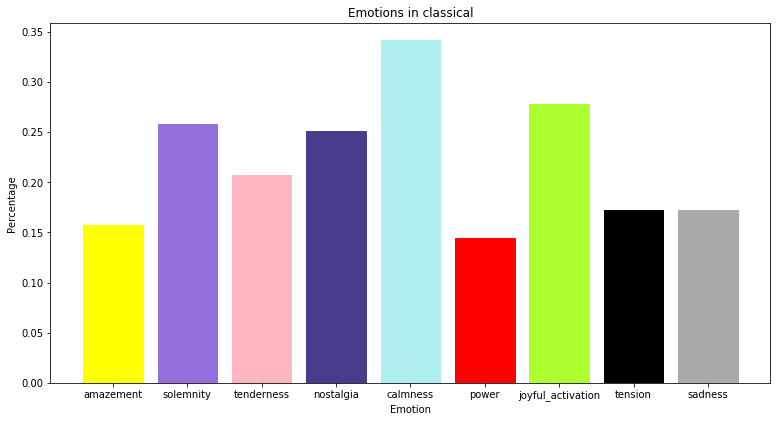

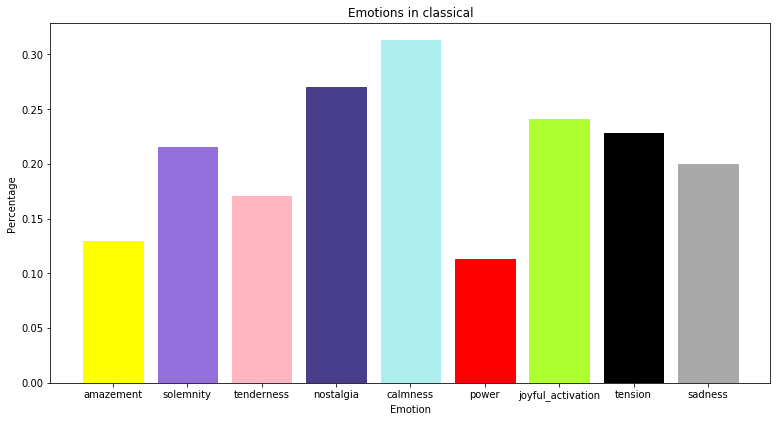

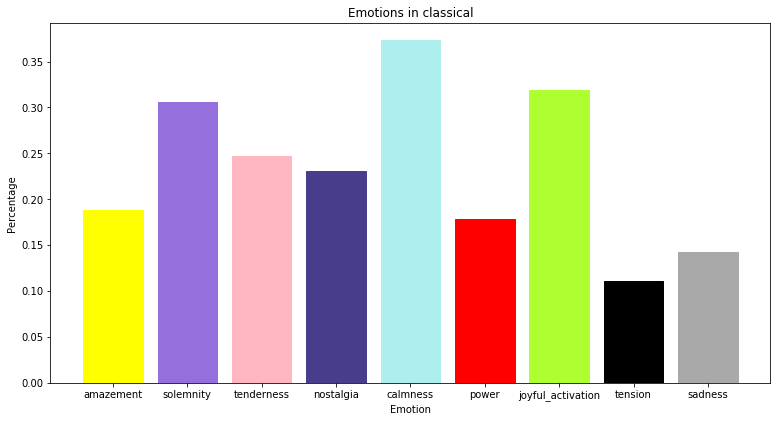

In [103]:
plot_bar_emotions(0,summarize_emotions)
plot_bar_emotions(0,summarize_emotions_dislike)
plot_bar_emotions(0,summarize_emotions_like)

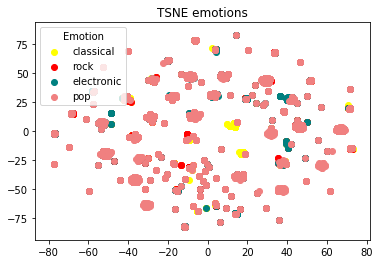

In [28]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_emotions)
fig,ax=plt.subplots()
ax.scatter(Xe[target=='classical',0],Xe[target=='classical',1],c="yellow",label="classical")
ax.scatter(Xe[target=='rock',0],Xe[target=='rock',1],c="red",label="rock")
ax.scatter(Xe[target=='electronic',0],Xe[target=='electronic',1],c="teal",label="electronic")
ax.scatter(Xe[target=='pop',0],Xe[target=='pop',1],c="lightcoral",label="pop")
plt.legend(loc='upper left',title="Emotion")
plt.title('TSNE emotions')
plt.show()

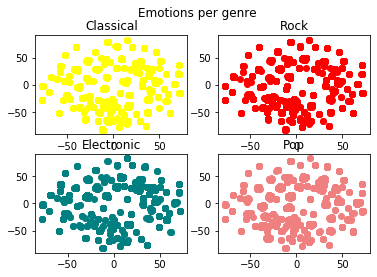

In [33]:
fig, ax = plt.subplots(2, 2)
ax[0,0].scatter(Xe[target=='classical',0],Xe[target=='classical',1],c="yellow",label="classical")
ax[0,1].scatter(Xe[target=='rock',0],Xe[target=='rock',1],c="red",label="rock")
ax[1,0].scatter(Xe[target=='electronic',0],Xe[target=='electronic',1],c="teal",label="electronic")
ax[1,1].scatter(Xe[target=='pop',0],Xe[target=='pop',1],c="lightcoral",label="pop")
ax[0,0].title.set_text('Classical')
ax[0,1].title.set_text('Rock')
ax[1,0].title.set_text('Electronic')
ax[1,1].title.set_text('Pop')
fig.suptitle("Emotions per genre")
plt.show()

In [36]:
data2_csv = pd.read_csv("mfccEmotify.csv",header=None)
data2 = pd.DataFrame(data2_csv).to_numpy()
data2.shape

(400, 86)

In [37]:
data2 = data2[~np.isnan(data2).any(axis=1)]
data2.shape

target = data2[:,-2]
X = data2[:,:-2]
order = data2[:,-1]
order = order.reshape(order.shape[0],1)
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(data2.shape,X.shape,order.shape)
X_complete = np.concatenate((X_norm, order), axis=1)

(379, 86) (379, 84) (379, 1)


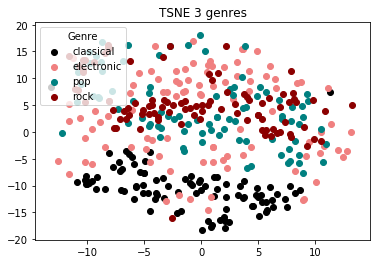

In [38]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==0,0],Xe[target==0,1],c="black",label="classical")
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="electronic")
ax.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="pop")
ax.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
plt.legend(loc='upper left',title="Genre")
plt.title('TSNE 3 genres')
plt.show()

In [39]:
def plot_emotions(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==0,0],Xe[target==0,1],c="black",label="classical")
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="electronic")
    ax1.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="pop")
    ax1.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
    ax2.scatter(Xe[pred==0,0],Xe[pred==0,1],c="black",label="classical")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="lightcoral",label="electronic")
    ax2.scatter(Xe[pred==2,0],Xe[pred==2,1],c="teal",label="pop")
    ax2.scatter(Xe[pred==3,0],Xe[pred==3,1],c="darkred",label="rock")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.set_size_inches(10, 5, forward=True)
    fig.suptitle(title)
    plt.show()

# Clustering Methods


In [40]:
# Substravtive Clustering
def substractive(data,ra,norm):
    import numpy as np
    from math import exp
    m,n = data.shape[0], data.shape[1]
    rb = 1.5*ra
    D = np.zeros((m,1))

    # Compute first center
    for i in range(m):
        for j in range(n):
            D[i] += exp(-np.linalg.norm(data[i,:]-data[j,:],norm)/(ra/2)**2)
    
    val = max(D)
    idx = np.argmax(D)
    ma = val
    centers = data[idx,:]
    cen = 0

    # Compute all centers until all the data is within the influence range of a cluster center
    while( ma > rb ):
        center = centers[cen,:]
        for i in range(m):
            sum = 0
            for  j in range(m):
                sum += exp(-np.linalg.norm(data[i,:]-center,norm)/(rb/2)**2)
            D[i] -= ma*sum
        val = max(D)
        idx = np.argmax(D)
        ma = val
        centers.append(data[idx,:],axis = 0)
        cen += 1

    return centers

In [42]:
ras = [1, 0.9, 0.8, 0.7]
results = np.empty((3,0))
for ra in ras:
    center_euclidean = substractive(data2,ra,2)
    center_1norm = substractive(data2,ra,1)
    center_infinity = substractive(data2,ra,math.inf)
    results = np.append(results,[[center_euclidean.shape[0]],[center_1norm.shape[0]],[center_infinity.shape[0]]],axis = 1)
pd.DataFrame(data=results, index=["Euclidean", "Cityblock","Infinito"], columns=["r_a = 1","r_a = 0.9","r_a = 0.8"," r_a = 0.7"])

,r_a = 1,r_a = 0.9,r_a = 0.8,r_a = 0.7
Euclidean,86.0,86.0,86.0,86.0
Cityblock,86.0,86.0,86.0,86.0
Infinito,86.0,86.0,86.0,86.0


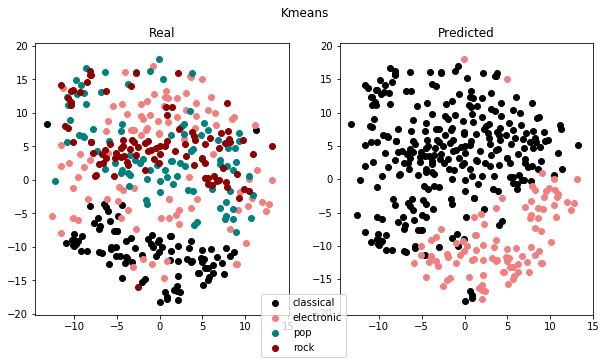

In [43]:
kmeans = KMeans(n_clusters=2).fit(X_norm)
plot_emotions(Xe,target,kmeans.labels_,"Kmeans")

Qué pasa si utilizamos 2 géneros?

(193, 84)


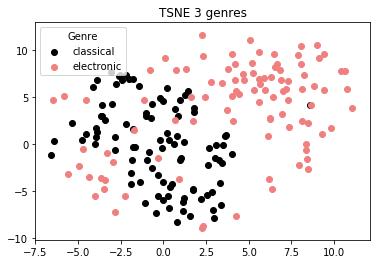

In [48]:
X_aux = np.append(X_norm[target==0],X_norm[target ==1],axis =0)
target_aux = np.append(target[target==0],target[target ==1],axis =0)
print(X_aux.shape)
Xe_2= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_aux)
fig,ax=plt.subplots()
ax.scatter(Xe_2[target_aux==0,0],Xe_2[target_aux==0,1],c="black",label="classical")
ax.scatter(Xe_2[target_aux==1,0],Xe_2[target_aux==1,1],c="lightcoral",label="electronic")
#ax.scatter(Xe_2[target==2,0],Xe_2[target==2,1],c="teal",label="pop")
#ax.scatter(Xe_2[target==3,0],Xe_2[target==3,1],c="darkred",label="rock")
plt.legend(loc='upper left',title="Genre")
plt.title('TSNE 3 genres')
plt.show()

In [51]:
def plot_2genres(genre1,genre2,X,target,name1,name2):
    X_aux = np.append(X_norm[target==genre1],X_norm[target == genre2],axis =0)
    target_aux = np.append(target[target==genre1],target[target == genre2],axis =0)
    print(X_aux.shape)
    Xe_2= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_aux)
    fig,ax=plt.subplots()
    ax.scatter(Xe_2[target_aux==genre1,0],Xe_2[target_aux==genre1,1],c="black",label=name1)
    ax.scatter(Xe_2[target_aux==genre2,0],Xe_2[target_aux==genre2,1],c="lightcoral",label=name2)
    plt.legend(loc='upper left',title="Genre")
    plt.title('TSNE 2 genres')
    plt.show()

(185, 84)


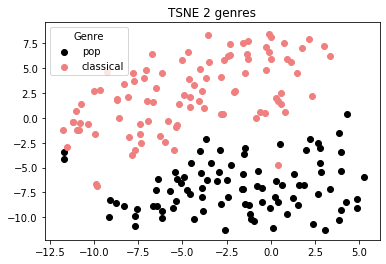

In [55]:
plot_2genres(2,0,X_norm,target,"pop","classical")

(193, 84)


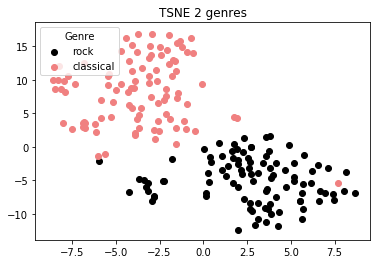

In [56]:
plot_2genres(3,0,X_norm,target,"rock","classical")

(193, 84)


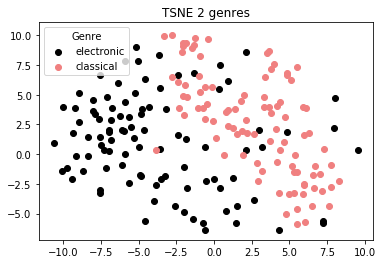

In [58]:
plot_2genres(1,0,X_norm,target,"electronic","classical")

(186, 84)


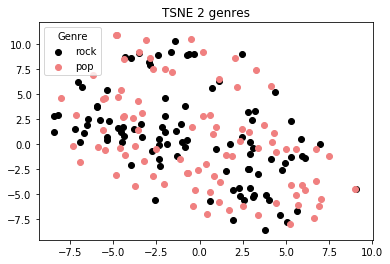

In [59]:
plot_2genres(3,2,X_norm,target,"rock","pop")

(186, 84)


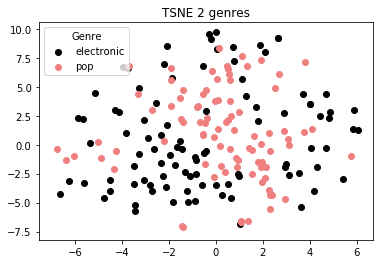

In [60]:
plot_2genres(1,2,X_norm,target,"electronic","pop")

(194, 84)


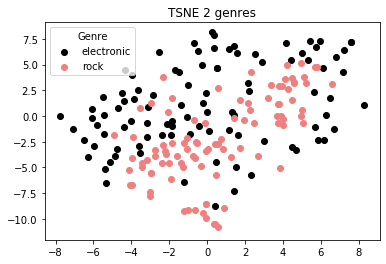

In [61]:
plot_2genres(1,3,X_norm,target,"electronic","rock")